In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [3]:
# Take the SW > 19
subjects = [sub for sub in subjects if sub[0:2]=='SW' and int(sub[2:].split('_')[0]) in set(range(19,36))]

In [4]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [5]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells200_7-7.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

## Analysis on SWISS 19-35 with father : threshold 200

In [6]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/dict_results_across_mice_SW19-35-200_7-7.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_SW19-35-200_7-7.npy', allow_pickle=True).item()

In [8]:
# removed key corresponding to SW21_Fam
dict_results_across_mice.pop('SW21_Fam')

,area,n_cells,energy
0,Frontal pole cerebral cortex,112,151002.907754
1,Primary motor area,185,30601.699705
2,Secondary motor area,465,58061.559705
3,Primary somatosensory area,290,23865.770545
4,Supplemental somatosensory area,73,19470.154174
...,...,...,...
194,Interfascicular nucleus raphe,41,434565.841256
195,Interpeduncular nucleus,44,134099.352738
196,Rostral linear nucleus raphe,7,103817.475604
197,Central linear nucleus raphe,1,9811.633176


In [9]:
subjects.remove('SW21_Fam')

# List areas with null cell count

In [10]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [11]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [12]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['SW25_Control',
  'SW19_Control',
  'SW24_Control',
  'SW31_Control',
  'SW30_Control'],
 'Unfam': ['SW26_Unfam',
  'SW20_Unfam',
  'SW22_Unfam',
  'SW28_Unfam',
  'SW34_Unfam',
  'SW32_Unfam'],
 'Fam': ['SW27_Fam', 'SW23_Fam', 'SW29_Fam', 'SW33_Fam', 'SW35_Fam']}

# Calculate cell count across experimental groups

In [13]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

## Calculate t-tests across groups per area

In [14]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.154496,0.502462,0.315718
1,Primary motor area,0.381668,0.723024,0.458554
2,Secondary motor area,0.335247,0.759052,0.347571
3,Primary somatosensory area,0.26386,0.534791,0.265154
4,Supplemental somatosensory area,0.210311,0.610961,0.209972
...,...,...,...,...
194,Interfascicular nucleus raphe,0.21032,0.0797425,0.855621
195,Interpeduncular nucleus,0.303847,0.227592,0.441301
196,Rostral linear nucleus raphe,0.208605,0.242787,0.518961
197,Central linear nucleus raphe,0.160878,0.181262,0.220415


In [15]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [16]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,9.42828e-06
Medial amygdalar nucleus,0.000335341
Posterior amygdalar nucleus,0.00049091
Piriform-amygdalar area,0.0155397
Cortical amygdalar area,0.0163615
Anterior tegmental nucleus,0.025424
Parastrial nucleus,0.025808
Pretectal region,0.0372075
Bed nuclei of the stria terminalis,0.046207


In [17]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.00039325
Ventral premammillary nucleus,0.000437913
Posterior amygdalar nucleus,0.00163554
Piriform-amygdalar area,0.0100305
Cortical amygdalar area,0.020129
Bed nucleus of the anterior commissure,0.0208483
Accessory olfactory bulb,0.0303958
Tuberal nucleus,0.032025
Septohippocampal nucleus,0.0337044


In [18]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nucleus of the anterior commissure,0.0113114
Paraventricular hypothalamic nucleus descending division,0.0202977
Septohippocampal nucleus,0.0512895
Preparasubthalamic nucleus,0.0593599
Dorsal auditory area,0.0605307
Perirhinal area,0.0624102
Caudoputamen,0.0755359
Superior colliculus sensory related,0.0785795
Posterior hypothalamic nucleus,0.0824787


## Mann Whitney Test for comparison across groups

In [19]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.148135,0.324038,0.117667
1,Primary motor area,0.148135,0.463632,0.157651
2,Secondary motor area,0.265435,0.463632,0.0854518
3,Primary somatosensory area,0.148135,0.463632,0.205657
4,Supplemental somatosensory area,0.105038,0.463632,0.117667
...,...,...,...,...
194,Interfascicular nucleus raphe,0.251906,0.0749698,0.46269
195,Interpeduncular nucleus,0.300201,0.157651,0.463632
196,Rostral linear nucleus raphe,0.220343,0.0972051,0.461767
197,Central linear nucleus raphe,0.333215,0.133907,0.463298


In [20]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [21]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.00609289
Medial amygdalar nucleus,0.00609289
Ventral premammillary nucleus,0.00609289
Infralimbic area,0.0107859
Tuberal nucleus,0.0107859
Parastrial nucleus,0.0139015
Piriform-amygdalar area,0.0139015
Anterior tegmental nucleus,0.0166693
Posterior limiting nucleus of the thalamus,0.0226007


In [22]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.00405656
Ventral premammillary nucleus,0.00405656
Posterior amygdalar nucleus,0.00405656
Accessory olfactory bulb,0.00674862
Bed nucleus of the anterior commissure,0.00820708
Piriform-amygdalar area,0.0112394
Tuberal nucleus,0.0112394
Cortical amygdalar area,0.0178819
Septohippocampal nucleus,0.0222753


In [23]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:35].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nucleus of the anterior commissure,0.00780586
Paraventricular hypothalamic nucleus descending division,0.0174631
Preparasubthalamic nucleus,0.0243304
Triangular nucleus of septum,0.0276171
Piriform area,0.0276171
Reticular nucleus of the thalamus,0.0414187
Superior colliculus sensory related,0.0414187
Septohippocampal nucleus,0.045292
Anterior tegmental nucleus,0.0474646


## Calculate cross corr across groups per area on cell count

In [24]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

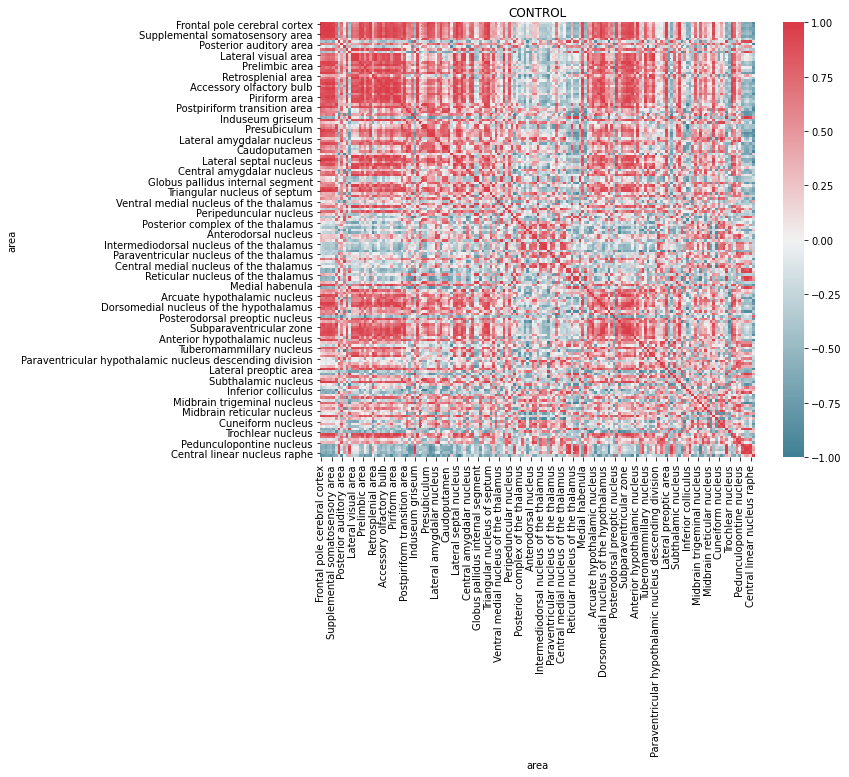

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

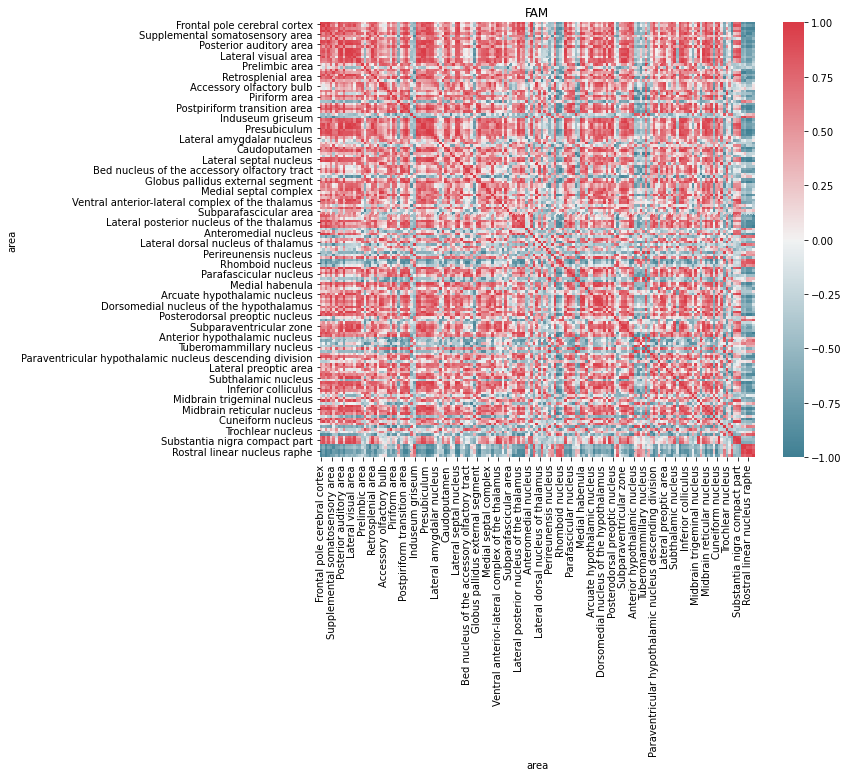

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

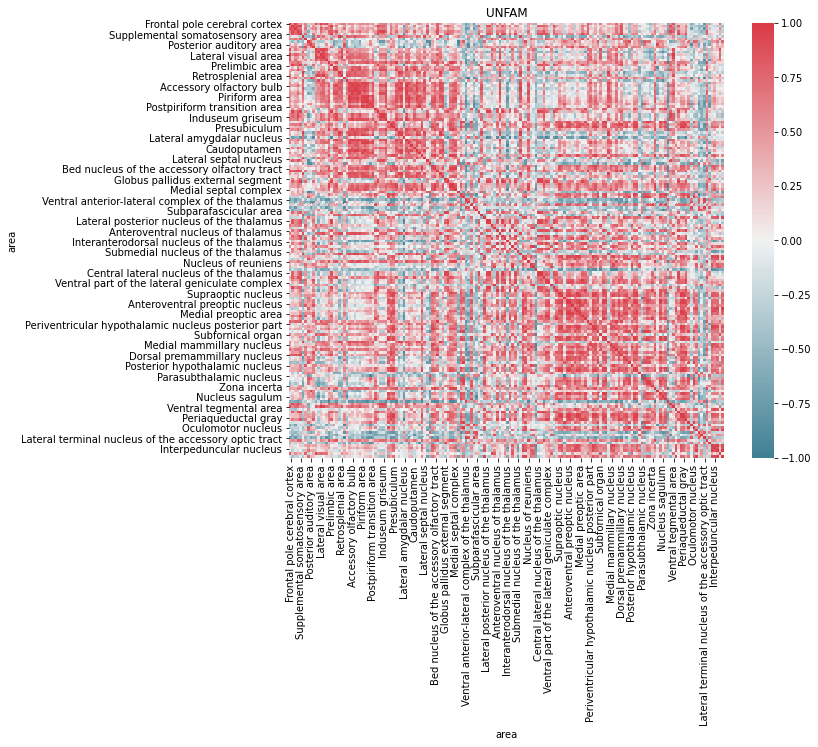

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [28]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [29]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)

In [30]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [31]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,0.000157461
Medial amygdalar nucleus,0.00073552
Posterior amygdalar nucleus,0.00215734
Cortical amygdalar area,0.00312903
Piriform-amygdalar area,0.00406156
Parastrial nucleus,0.0142044
Tuberal nucleus,0.0309618
Anterior tegmental nucleus,0.0386704
Pretectal region,0.0447081


In [32]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,0.000292194
Medial amygdalar nucleus,0.00035262
Posterior amygdalar nucleus,0.00342263
Piriform-amygdalar area,0.00557065
Cortical amygdalar area,0.00924557
Bed nucleus of the anterior commissure,0.0170075
Tuberal nucleus,0.0341206
Septohippocampal nucleus,0.0348679
Main olfactory bulb,0.0530326


In [33]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nucleus of the anterior commissure,0.00891749
Paraventricular hypothalamic nucleus descending division,0.0253475
Septohippocampal nucleus,0.0488678
Perirhinal area,0.0550902
Dorsal auditory area,0.0703325
Superior colliculus sensory related,0.0831747
Reticular nucleus of the thalamus,0.0897292
Ventral part of the lateral geniculate complex,0.100132
Caudoputamen,0.113198


## Mann-Whitney Test across groups

In [34]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')

In [35]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [36]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:40].set_index('area')

,pval_Control_vs_Fam
area,
Medial amygdalar nucleus,0.00609289
Lateral strip of striatum,0.00609289
Substantia nigra lateral part,0.00609289
Posterior amygdalar nucleus,0.00609289
Retroethmoid nucleus,0.00609289
Pineal body,0.00609289
Nucleus circularis,0.00609289
Anterior hypothalamic area,0.00609289
Parastrial nucleus,0.00609289


In [37]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:50].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.00405656
Posterior amygdalar nucleus,0.00405656
Lateral strip of striatum,0.00405656
Suprachiasmatic preoptic nucleus,0.00405656
Anterior hypothalamic area,0.00405656
Intercollicular nucleus,0.00405656
Ventral premammillary nucleus,0.00405656
Nucleus circularis,0.00405656
Substantia nigra lateral part,0.00405656


In [38]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:50].set_index('area')

,pval_Control_vs_Fam
area,
Retroethmoid nucleus,0.00609289
Suprachiasmatic preoptic nucleus,0.00609289
Nucleus circularis,0.00609289
Pineal body,0.00609289
Anterior hypothalamic area,0.00609289
Lateral strip of striatum,0.00609289
Intercollicular nucleus,0.00609289
Substantia nigra lateral part,0.00609289
Bed nucleus of the anterior commissure,0.327918


## Calculate cross corr matrix across experimental groups on energy

In [39]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

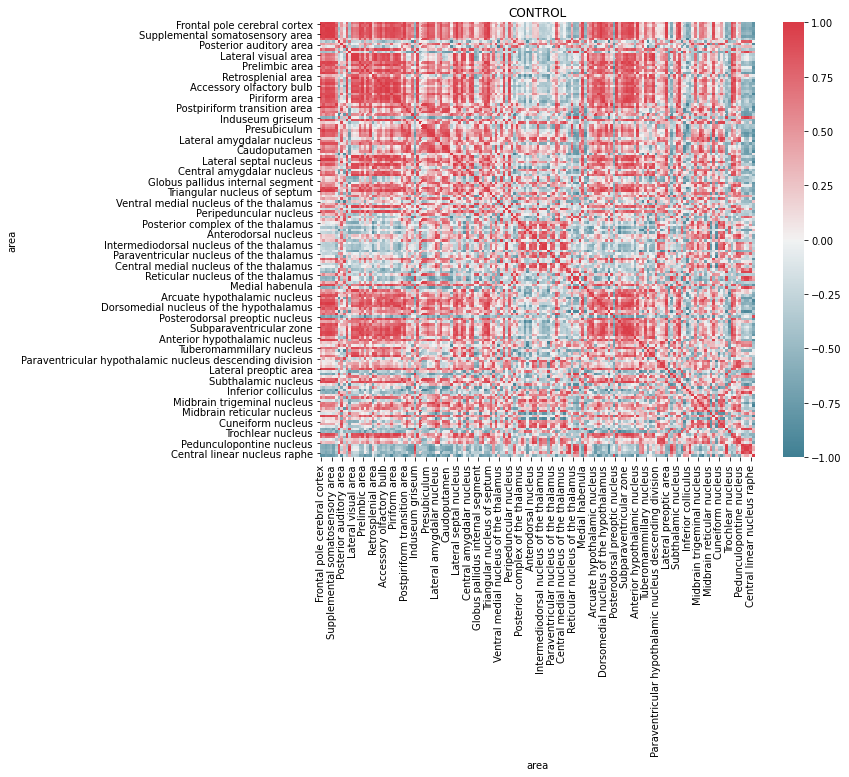

In [40]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

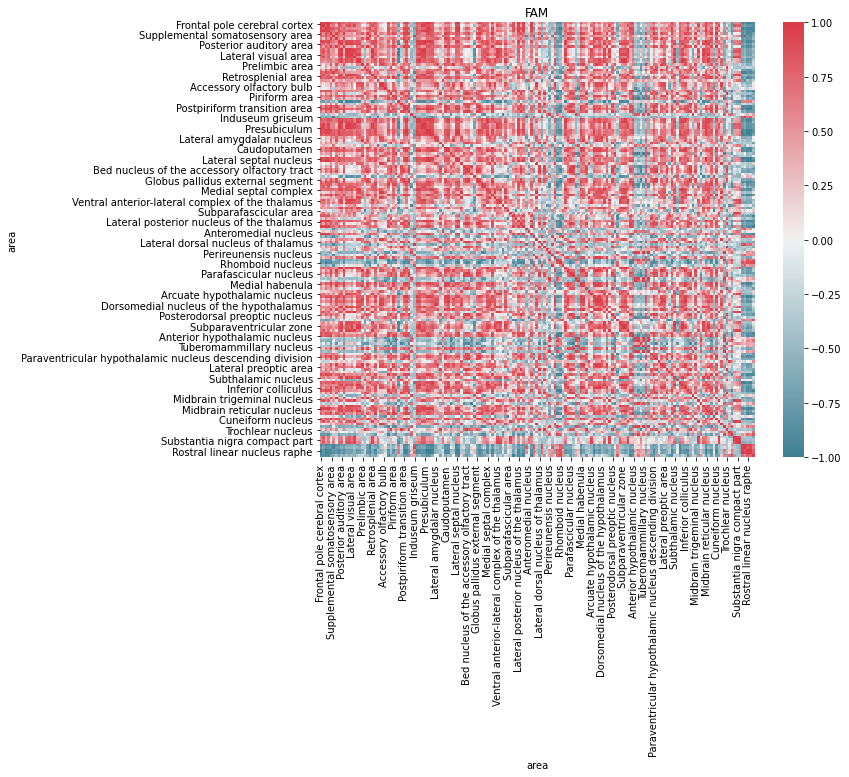

In [41]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

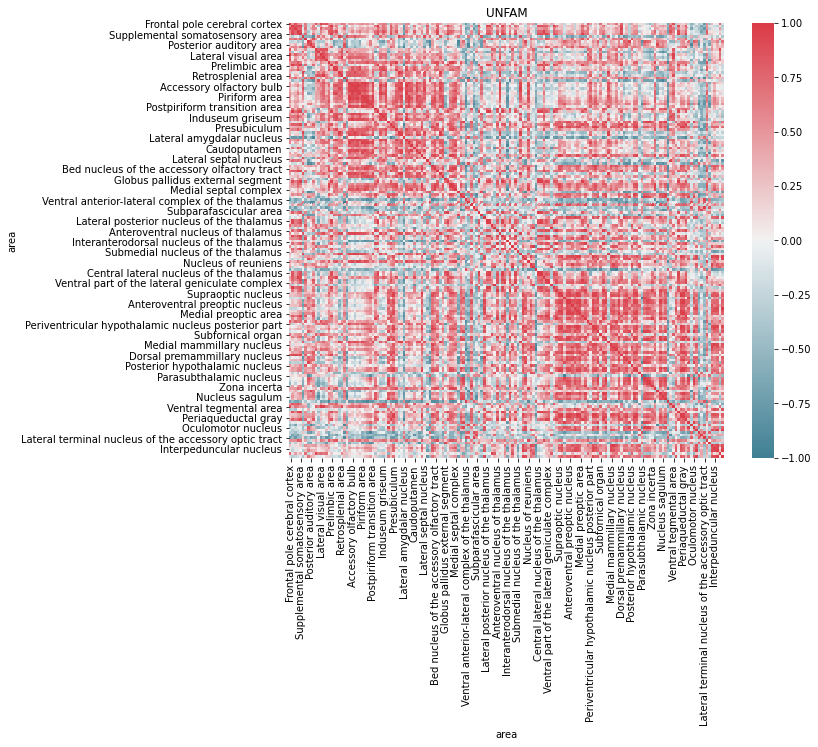

In [42]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')